In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import gc
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import plotly.express as px
from pylab import rcParams
# for Q-Q plots
import scipy.stats as stats
import seaborn as sns
sns.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
from sklearn.metrics import mean_absolute_error
import catboost as catt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss,roc_auc_score,accuracy_score

# from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/umojahack-cryptojacking/SampleSubmission.csv
/kaggle/input/umojahack-cryptojacking/Cryptojacking_Detection_Starter_Notebook.ipynb
/kaggle/input/umojahack-cryptojacking/Train.csv
/kaggle/input/umojahack-cryptojacking/Test.csv
/kaggle/input/umojahack-cryptojacking/Variable_Definitions.csv


In [2]:
#import datasets
train = pd.read_csv("../input/umojahack-cryptojacking/Train.csv")
test = pd.read_csv("../input/umojahack-cryptojacking/Test.csv")
SampleSubmission = pd.read_csv("../input/umojahack-cryptojacking/SampleSubmission.csv")

In [3]:
ntrain= train.shape[0]
ntest = test.shape[0]
train_set = pd.concat((train, test)).reset_index(drop=True)

In [4]:
train.head()

,ID,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius,Label
0,ID_4W8AP96UO6,114.798900,3790.450939,28.0,0.427078,6.162365,21.220403,58.492773,63.959387,0.621206,0.521813,24.624612,0.0,1001.533430,27.190843,1
1,ID_UD3TM0ZYND,14.154240,5182.451722,28.0,0.138876,5.399498,0.000000,22.886762,29.508369,0.422183,0.444403,0.044440,0.0,1089.121009,30.150941,0
2,ID_XAG1HC0HWM,0.044444,120.821253,28.0,0.000000,1.577765,0.000000,11.733239,12.888786,0.177776,0.155554,0.044444,0.0,322.464081,28.163287,0
3,ID_CEXD05IR09,31.369916,127228.251100,31.0,0.523750,15.981107,5.356671,602.125436,6976.986795,3.311801,5.756755,5.623394,0.0,12015.169690,34.204404,0
4,ID_X6E97FT8IF,5.046181,1091.620117,25.0,0.069468,1.356022,0.000000,16.138887,13.271234,0.155609,0.133379,0.000000,0.0,550.989619,31.466889,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8908 entries, 0 to 8907
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        8908 non-null   object 
 1   I/O Data Operations       8908 non-null   float64
 2    I/O Data Bytes           8908 non-null   float64
 3   Number of subprocesses    8908 non-null   float64
 4   Time on processor         8908 non-null   float64
 5   Disk Reading/sec          8908 non-null   float64
 6   Disc Writing/sec          8908 non-null   float64
 7   Bytes Sent/sent           8908 non-null   float64
 8   Received Bytes (HTTP)     8908 non-null   float64
 9   Network packets sent      8908 non-null   float64
 10  Network packets received  8908 non-null   float64
 11  Pages Read/sec            8908 non-null   float64
 12  Pages Input/sec           8908 non-null   float64
 13  Page Errors/sec           8908 non-null   float64
 14  Confirme

In [6]:
train.shape

(8908, 16)

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
I/O Data Operations,8908.0,36.429205,75.884647,0.000000,1.394404,11.613803,34.494953,1.795316e+03
I/O Data Bytes,8908.0,113556.435854,489684.616342,0.000000,813.631825,4930.481627,39403.570772,4.677280e+06
Number of subprocesses,8908.0,29.811900,5.691411,1.000000,27.000000,28.000000,30.000000,5.100000e+01
Time on processor,8908.0,0.496405,1.593626,0.000000,0.000000,0.034734,0.451350,2.524615e+01
Disk Reading/sec,8908.0,5.353260,19.286690,0.044459,0.755629,1.711077,5.845619,1.064819e+03
Disc Writing/sec,8908.0,1.046153,15.667814,0.000000,0.000000,0.000000,0.022229,8.315039e+02
Bytes Sent/sent,8908.0,559.546628,1939.745234,1.197890,33.843800,67.366295,221.314810,9.809778e+04
Received Bytes (HTTP),8908.0,16558.044068,90428.025210,1.554938,27.377705,89.057696,561.381397,4.812144e+06
Network packets sent,8908.0,4.795485,20.797585,0.022183,0.399999,0.710898,1.555063,1.118878e+03
Network packets received,8908.0,12.625792,61.246541,0.022183,0.333225,0.635705,1.711155,3.183701e+03


In [8]:
# Replace all 0.000 values with NaN
train.replace(0.000, np.nan, inplace=True)
test.replace(0.000, np.nan, inplace = True)

In [9]:
train.head(5)

,ID,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius,Label
0,ID_4W8AP96UO6,114.798900,3790.450939,28.0,0.427078,6.162365,21.220403,58.492773,63.959387,0.621206,0.521813,24.624612,NaN,1001.533430,27.190843,1.0
1,ID_UD3TM0ZYND,14.154240,5182.451722,28.0,0.138876,5.399498,NaN,22.886762,29.508369,0.422183,0.444403,0.044440,NaN,1089.121009,30.150941,NaN
2,ID_XAG1HC0HWM,0.044444,120.821253,28.0,NaN,1.577765,NaN,11.733239,12.888786,0.177776,0.155554,0.044444,NaN,322.464081,28.163287,NaN
3,ID_CEXD05IR09,31.369916,127228.251100,31.0,0.523750,15.981107,5.356671,602.125436,6976.986795,3.311801,5.756755,5.623394,NaN,12015.169690,34.204404,NaN
4,ID_X6E97FT8IF,5.046181,1091.620117,25.0,0.069468,1.356022,NaN,16.138887,13.271234,0.155609,0.133379,NaN,NaN,550.989619,31.466889,1.0


In [10]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

In [11]:
# Check for duplicates
train.isnull().sum().any(), test.isnull().sum().any()

(True, True)

In [12]:
percent_missing = train.isnull().sum() * 100 / len(train)
missing_values_train = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing})
missing_values_train


,column_name,percent_missing
ID,ID,0.000000
I/O Data Operations,I/O Data Operations,9.418500
I/O Data Bytes,I/O Data Bytes,9.418500
Number of subprocesses,Number of subprocesses,0.000000
Time on processor,Time on processor,41.097890
Disk Reading/sec,Disk Reading/sec,0.000000
Disc Writing/sec,Disc Writing/sec,69.802425
Bytes Sent/sent,Bytes Sent/sent,0.000000
Received Bytes (HTTP),Received Bytes (HTTP),0.000000
Network packets sent,Network packets sent,0.000000


In [13]:
train['I/O Data Operations'] = train['I/O Data Operations'].fillna(train['I/O Data Operations'].mean())
test['I/O Data Operations'] = test['I/O Data Operations'].fillna(test['I/O Data Operations'].mean())

train[' I/O Data Bytes'] = train[' I/O Data Bytes'].fillna(train[' I/O Data Bytes'].mean())
test[' I/O Data Bytes'] = test[' I/O Data Bytes'].fillna(test[' I/O Data Bytes'].mean())


train['Pages Read/sec'] = train['Pages Read/sec'].fillna(train['Pages Read/sec'].mean())
test['Pages Read/sec'] = test['Pages Read/sec'].fillna(test['Pages Read/sec'].mean())

train['Time on processor'] = train['Time on processor'].fillna(train['Time on processor'].mean())
test['Time on processor'] = test['Time on processor'].fillna(test['Time on processor'].mean())

In [14]:
percent_missing = test.isnull().sum() * 100 / len(test)
missing_values_test = pd.DataFrame({'column_name': test.columns,
                                 'percent_missing': percent_missing})
missing_values_test


,column_name,percent_missing
ID,ID,0.000000
I/O Data Operations,I/O Data Operations,0.000000
I/O Data Bytes,I/O Data Bytes,0.000000
Number of subprocesses,Number of subprocesses,0.000000
Time on processor,Time on processor,0.000000
Disk Reading/sec,Disk Reading/sec,0.000000
Disc Writing/sec,Disc Writing/sec,70.350969
Bytes Sent/sent,Bytes Sent/sent,0.000000
Received Bytes (HTTP),Received Bytes (HTTP),0.000000
Network packets sent,Network packets sent,0.000000


In [15]:
#cols to drop
high_miss_val =['Disc Writing/sec', "Pages Input/sec"]
train = train.drop(high_miss_val, axis=1)
test = test.drop(high_miss_val,axis=1)

# **Explore Data(EDA)**

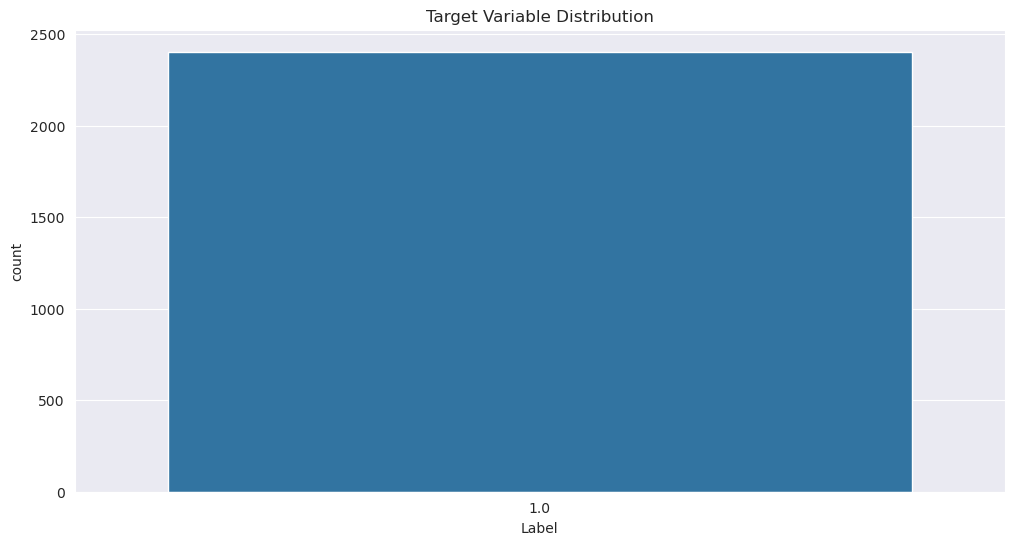

In [16]:
#Target value distribution
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.countplot(x = 'Label', data = train)
plt.title('Target Variable Distribution')
plt.show()

In [17]:
from scipy.stats import skew 
print("The skewness of the I/O D_O feature is: ", train['I/O Data Operations'].skew())
print("The skewness of the I/O D_B feature is: ", train[' I/O Data Bytes'].skew())

The skewness of the I/O D_O feature is:  7.435873440152207
The skewness of the I/O D_B feature is:  5.960240914134111


In [18]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

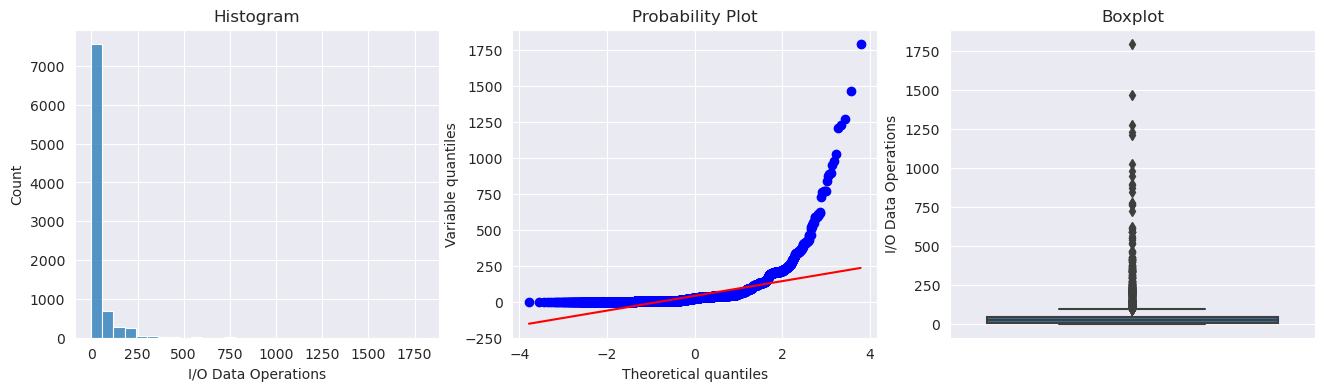

In [19]:
diagnostic_plots(train, "I/O Data Operations")

In [20]:
#from the above plots we can see the data is skewed, and has a lot of outliers

**Feature Eng**

In [21]:
train["I/O_bytes"] = train["I/O Data Operations"]/train[" I/O Data Bytes"]
test["I/O_bytes"] = test["I/O Data Operations"]/test[" I/O Data Bytes"]

In [22]:
from scipy.stats import norm
def distribution_plot(df, variable):
    plt.figure(figsize=(16, 8))

    # boxplot
    plt.subplot(1, 4, 1)
    sns.boxplot(df[variable])
    plt.title('Boxplot')

    # distplot
    plt.subplot(1, 4, 2)
    sns.distplot(df[variable], fit=norm)
    plt.title('distplot')

    
#      # boxplot
#     plt.subplot(1, 4, 3)
#     sns.boxplot(np.log(df[variable]))
#     plt.title('Boxplot')

#     # distplot
#     plt.subplot(1, 4, 4)
#     sns.distplot(np.log(df[variable]))
#     plt.title('distplot')

    plt.show()

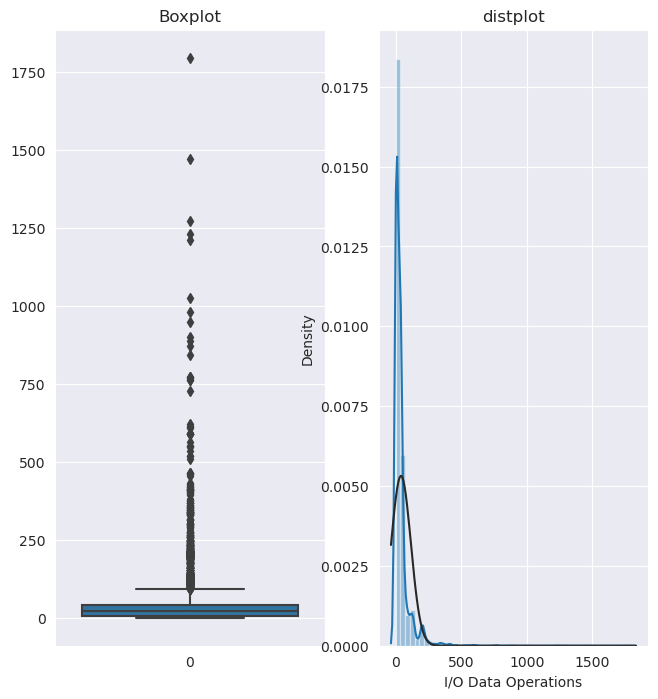

In [23]:
distribution_plot(train, 'I/O Data Operations')

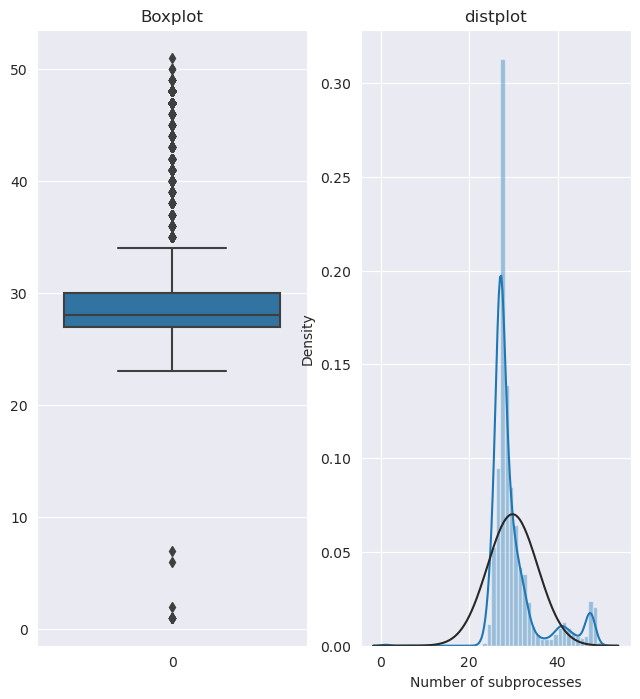

In [24]:
distribution_plot(train, "Number of subprocesses")

In [25]:
# train["I/O Data Operations"] = np.log1p(train["I/O Data Operations"])
# test["I/O Data Operations"] = np.log(test["I/O Data Operations"])


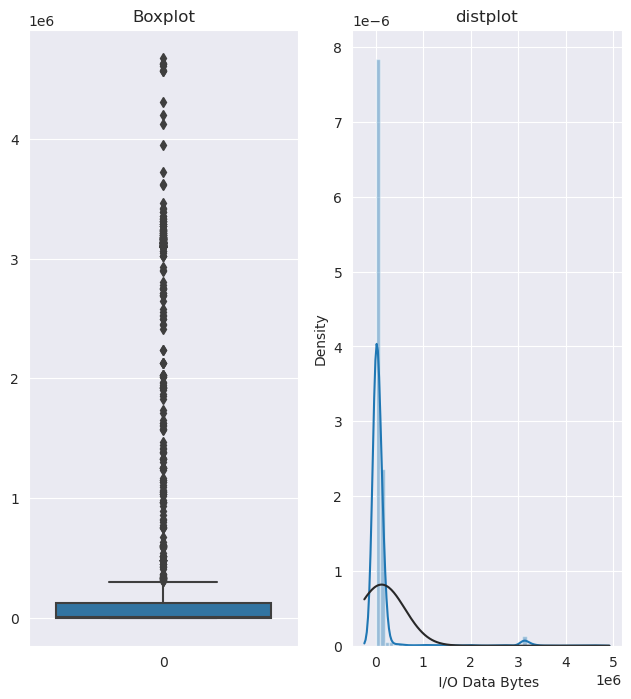

In [26]:
distribution_plot(train, ' I/O Data Bytes')

In [27]:
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [28]:
def remove_outliers(df, threshold=3):
    # Calculate Z-score for each column in the DataFrame
    z_scores = np.abs((df - df.mean()) / df.std())
    
    # Identify rows with any Z-score greater than the threshold
    outliers = z_scores.apply(lambda x: np.any(x > threshold), axis=1)
    
    # Remove outliers from DataFrame
    df = df[~outliers]
    
    return df
remove_outliers(train)

,ID,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Page Errors/sec,Confirmed byte radius,Label,I/O_bytes
1,ID_UD3TM0ZYND,14.154240,5182.451722,28.0,0.138876,5.399498,22.886762,29.508369,0.422183,0.444403,0.044440,1089.121009,30.150941,NaN,0.002731
2,ID_XAG1HC0HWM,0.044444,120.821253,28.0,0.842762,1.577765,11.733239,12.888786,0.177776,0.155554,0.044444,322.464081,28.163287,NaN,0.000368
3,ID_CEXD05IR09,31.369916,127228.251100,31.0,0.523750,15.981107,602.125436,6976.986795,3.311801,5.756755,5.623394,12015.169690,34.204404,NaN,0.000247
4,ID_X6E97FT8IF,5.046181,1091.620117,25.0,0.069468,1.356022,16.138887,13.271234,0.155609,0.133379,1.671685,550.989619,31.466889,1.0,0.004623
5,ID_J1YVGQ3RS4,6.891100,1694.254741,27.0,0.842762,1.022550,87.717034,94.385841,0.733569,0.733569,0.022229,320.636215,27.690737,NaN,0.004067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8903,ID_XJWM9B7X4L,26.769658,6965.281426,25.0,0.155955,1.497184,252.525113,589.072219,0.858386,0.758573,0.019962,1177.825039,30.875026,1.0,0.003843
8904,ID_YIC5VRPLUD,40.217048,125363.828305,27.0,0.842762,0.400009,28.089513,27.267273,0.400009,0.355563,1.671685,221.249363,23.503856,NaN,0.000321
8905,ID_T3RF72SEG1,0.866827,853.957842,29.0,0.842762,4.378587,20.559356,26.093712,0.333395,0.355621,0.022226,262.270699,21.060478,NaN,0.001015
8906,ID_2AUQFJYWKV,0.044430,16.527885,28.0,0.842762,0.888596,74.375484,116.650437,0.555372,0.377653,1.671685,268.222697,24.775056,NaN,0.002688


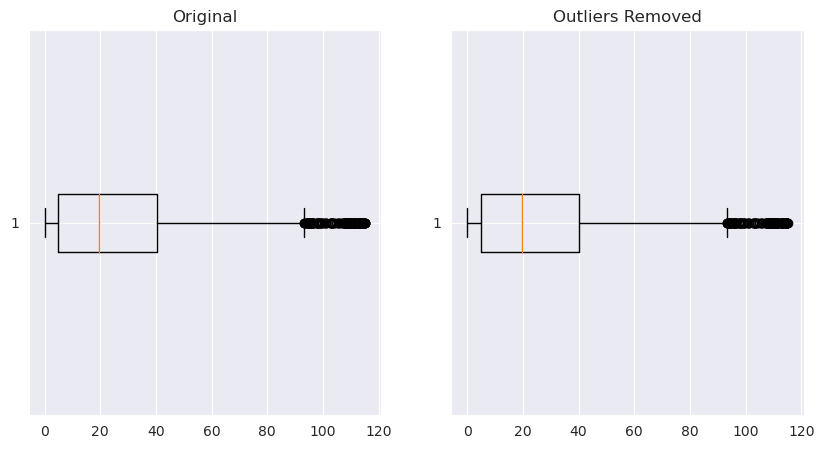

In [29]:
def detect_and_plot_outliers(df, column_name, threshold=1):


    # Calculate the Z-scores for the column
    z_scores = (df[column_name] - df[column_name].mean()) / df[column_name].std()

    # Identify the outliers using the threshold
    outliers = df[np.abs(z_scores) > threshold]

    # Remove the outliers from the dataset
    df = df[np.abs(z_scores) <= threshold]

    # Plot the original and modified columns
    fig, ax = plt.subplots(1, 2, figsize=(10,5))

    ax[0].boxplot(df[column_name], vert=False)
    ax[0].set_title("Original")

    ax[1].boxplot(df[column_name], vert=False)
    ax[1].set_title("Outliers Removed")

    plt.show()
detect_and_plot_outliers(train, "I/O Data Operations")

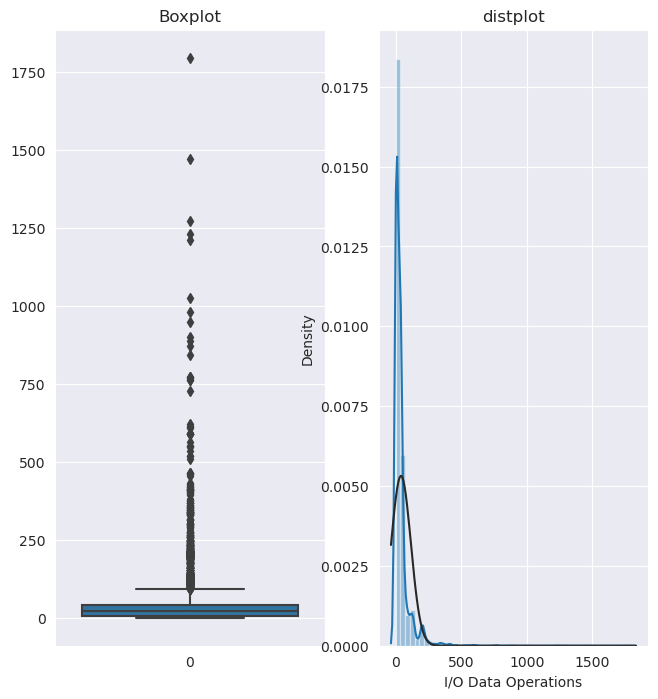

In [30]:
distribution_plot(train, 'I/O Data Operations')

In [31]:
unwanted = ["ID", "Label"]
columns = [col for col in train.columns if col not in unwanted]
print(columns)
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
transformer = FunctionTransformer(np.log, validate=True)
# train= transformer.transform(train[columns])

['I/O Data Operations', ' I/O Data Bytes', 'Number of subprocesses', 'Time on processor', 'Disk Reading/sec', 'Bytes Sent/sent', 'Received Bytes (HTTP)', 'Network packets sent', 'Network packets received', 'Pages Read/sec', 'Page Errors/sec', 'Confirmed byte radius', 'I/O_bytes']


In [32]:
train

,ID,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Page Errors/sec,Confirmed byte radius,Label,I/O_bytes
0,ID_4W8AP96UO6,114.798900,3790.450939,28.0,0.427078,6.162365,58.492773,63.959387,0.621206,0.521813,24.624612,1001.533430,27.190843,1.0,0.030286
1,ID_UD3TM0ZYND,14.154240,5182.451722,28.0,0.138876,5.399498,22.886762,29.508369,0.422183,0.444403,0.044440,1089.121009,30.150941,NaN,0.002731
2,ID_XAG1HC0HWM,0.044444,120.821253,28.0,0.842762,1.577765,11.733239,12.888786,0.177776,0.155554,0.044444,322.464081,28.163287,NaN,0.000368
3,ID_CEXD05IR09,31.369916,127228.251100,31.0,0.523750,15.981107,602.125436,6976.986795,3.311801,5.756755,5.623394,12015.169690,34.204404,NaN,0.000247
4,ID_X6E97FT8IF,5.046181,1091.620117,25.0,0.069468,1.356022,16.138887,13.271234,0.155609,0.133379,1.671685,550.989619,31.466889,1.0,0.004623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8903,ID_XJWM9B7X4L,26.769658,6965.281426,25.0,0.155955,1.497184,252.525113,589.072219,0.858386,0.758573,0.019962,1177.825039,30.875026,1.0,0.003843
8904,ID_YIC5VRPLUD,40.217048,125363.828305,27.0,0.842762,0.400009,28.089513,27.267273,0.400009,0.355563,1.671685,221.249363,23.503856,NaN,0.000321
8905,ID_T3RF72SEG1,0.866827,853.957842,29.0,0.842762,4.378587,20.559356,26.093712,0.333395,0.355621,0.022226,262.270699,21.060478,NaN,0.001015
8906,ID_2AUQFJYWKV,0.044430,16.527885,28.0,0.842762,0.888596,74.375484,116.650437,0.555372,0.377653,1.671685,268.222697,24.775056,NaN,0.002688


# ***MODELLING***

In [33]:
train["Label"] = train["Label"].fillna(0)
features = train.drop(columns=['ID','Label']).columns
target = 'Label'

# transform data
X = train[features]
y = train["Label"]


In [34]:
X

,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Page Errors/sec,Confirmed byte radius,I/O_bytes
0,114.798900,3790.450939,28.0,0.427078,6.162365,58.492773,63.959387,0.621206,0.521813,24.624612,1001.533430,27.190843,0.030286
1,14.154240,5182.451722,28.0,0.138876,5.399498,22.886762,29.508369,0.422183,0.444403,0.044440,1089.121009,30.150941,0.002731
2,0.044444,120.821253,28.0,0.842762,1.577765,11.733239,12.888786,0.177776,0.155554,0.044444,322.464081,28.163287,0.000368
3,31.369916,127228.251100,31.0,0.523750,15.981107,602.125436,6976.986795,3.311801,5.756755,5.623394,12015.169690,34.204404,0.000247
4,5.046181,1091.620117,25.0,0.069468,1.356022,16.138887,13.271234,0.155609,0.133379,1.671685,550.989619,31.466889,0.004623
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8903,26.769658,6965.281426,25.0,0.155955,1.497184,252.525113,589.072219,0.858386,0.758573,0.019962,1177.825039,30.875026,0.003843
8904,40.217048,125363.828305,27.0,0.842762,0.400009,28.089513,27.267273,0.400009,0.355563,1.671685,221.249363,23.503856,0.000321
8905,0.866827,853.957842,29.0,0.842762,4.378587,20.559356,26.093712,0.333395,0.355621,0.022226,262.270699,21.060478,0.001015
8906,0.044430,16.527885,28.0,0.842762,0.888596,74.375484,116.650437,0.555372,0.377653,1.671685,268.222697,24.775056,0.002688


In [35]:
y

0       1.0
1       0.0
2       0.0
3       0.0
4       1.0
       ... 
8903    1.0
8904    0.0
8905    0.0
8906    0.0
8907    0.0
Name: Label, Length: 8908, dtype: float64

In [36]:
from sklearn.model_selection import StratifiedKFold, KFold
from imblearn.over_sampling import  RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
fold_pred=[]
oof_pred = []

params =     params = {
        'iterations':10000,
        'random_state':42,
        'max_depth': 7,
        'learning_rate': 0.008436034013684798,
        'l2_leaf_reg': 0.8908564261285311,
         }

fold= StratifiedKFold(n_splits=5)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    sm = SMOTE(random_state = 42)
    X_train_s, y_train_s = sm.fit_resample(X_train, y_train)
   

    model = catt.CatBoostClassifier(bootstrap_type='Bernoulli', task_type="CPU", **params)

    model.fit(X_train,y_train,eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose = False)#erly100

    preds= model.predict_proba(X_test)
    print("err: ",(log_loss(y_test,preds)))  
    oof_pred.append(log_loss(y_test,preds))
    p2 = model.predict_proba(test[X.columns])
    fold_pred.append(p2)
    
print(np.mean(oof_pred)) 


err:  0.05900428854463936
err:  0.05737133401897166
err:  0.06282255639174142
err:  0.059433830279340974
err:  0.054323578717504775
0.05859111759043963


In [37]:
len(fold_pred[1])

3818

In [38]:
submission_df = test[["ID"]].copy()
submission_df["Label"]=np.round(np.mean([pred[:, 1] for pred in fold_pred], axis=0))
submission_df.head(5)

,ID,Label
0,ID_L7RNFK5JC9,0.0
1,ID_KUTY5K1G5F,0.0
2,ID_H6PJWKU831,1.0
3,ID_DNQXNVTXHE,1.0
4,ID_8CRTF1BJOD,0.0


In [39]:
submission_df.to_csv("baseline13.csv", index=False)

In [40]:
pd.options.display.max_rows = 2200
#define a function to create variable importance dataframe
def get_catt_varimp(model, train_columns, max_vars=350):
   
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df
#
get_catt_varimp(model, X.columns)

,feature_name,varimp (%)
0,I/O Data Operations,21.786502
12,I/O_bytes,16.131774
1,I/O Data Bytes,10.809288
10,Page Errors/sec,8.43994
4,Disk Reading/sec,7.180719
3,Time on processor,6.655836
11,Confirmed byte radius,6.340346
2,Number of subprocesses,5.482709
6,Received Bytes (HTTP),5.391615
8,Network packets received,3.745044
